### NER

- word2vec, google-news-300
- bilstm
- crf

In [1]:
# import library
import pandas as pd
import numpy as np
import tensorflow as tf
import string
import re
import random
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import word2vec, FastText
import gensim.downloader
from sklearn.decomposition import PCA

In [2]:
import pandas as pd
df = pd.read_csv(('data/ner_dataset.csv'),encoding = 'unicode_escape')
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [3]:
df['Sentence #']=df['Sentence #'].ffill()
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


In [4]:
df = df[['Sentence #','Word','Tag']]
df.rename(columns = {'Sentence #':'Sentence'},inplace = True)
df

C:\Users\tqin0\AppData\Local\Temp\ipykernel_12604\4266400182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns = {'Sentence #':'Sentence'},inplace = True)


,Sentence,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
...,...,...,...
1048570,Sentence: 47959,they,O
1048571,Sentence: 47959,responded,O
1048572,Sentence: 47959,to,O
1048573,Sentence: 47959,the,O


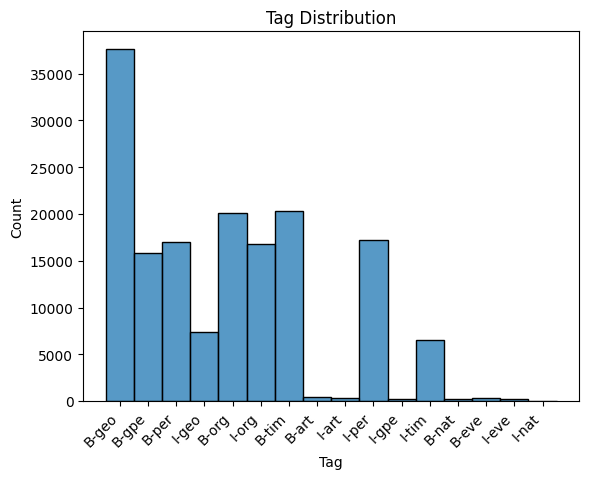

In [5]:
# show pos distribution
sns.histplot(df[df['Tag'] != 'O']['Tag'])
plt.xticks(rotation = 45, ha = 'right')
plt.title('Tag Distribution')
plt.show()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Sentence  1048575 non-null  object
 1   Word      1048565 non-null  object
 2   Tag       1048575 non-null  object
dtypes: object(3)
memory usage: 24.0+ MB


In [7]:
print('Unique sentences number - ' + str(df['Sentence'].nunique()))
print('Unique vocabs number - ' + str(df['Word'].nunique())) # 此时word中同时存在大小写

Unique sentences number - 47959
Unique vocabs number - 35177


Build model

In [8]:
import xml.etree.ElementTree as ET
# 一种以编程方式处理 XML 文档的方法

import tensorflow as tf

from tensorflow.keras.layers import TextVectorization
# 导入了 TextVectorization 层。这个层用于对文本数据进行预处理,将其转换为数字表示,
# 以便作为神经网络的输入

import gensim.downloader as api
# downloader 模块提供了一种下载预训练词嵌入的方法,词嵌入是对单词的数字化表示,
# 可以捕捉它们之间的语义和语法关系

from tensorflow.keras.layers import Embedding
# Embedding 层用于创建单词的密集的低维向量表示,可以作为神经网络的输入

tf.random.set_seed(123)
# 为 TensorFlow 的随机数生成器设置了种子为 123。这确保了任何随机操作,
# 如权重初始化或数据洗牌,在不同的运行中都是可重现的

In [9]:
df['Word'] = df['Word'].str.lower()
df.head()

C:\Users\tqin0\AppData\Local\Temp\ipykernel_12604\3681788111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Word'] = df['Word'].str.lower()


,Sentence,Word,Tag
0,Sentence: 1,thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


In [10]:
sentence_all = [(list(zip(group['Word'], group['Tag']))) for _, group in df.groupby('Sentence')]
sentence_all[0:2]
# sentence_all 变量存储了一个列表,列表中的每个元素都是一个句子中所有单词及其词性标注的列表
# 这段代码的作用是将 DataFrame 中的数据转换成一种更加适合后续自然语言处理任务的格式

[[('thousands', 'O'),
  ('of', 'O'),
  ('demonstrators', 'O'),
  ('have', 'O'),
  ('marched', 'O'),
  ('through', 'O'),
  ('london', 'B-geo'),
  ('to', 'O'),
  ('protest', 'O'),
  ('the', 'O'),
  ('war', 'O'),
  ('in', 'O'),
  ('iraq', 'B-geo'),
  ('and', 'O'),
  ('demand', 'O'),
  ('the', 'O'),
  ('withdrawal', 'O'),
  ('of', 'O'),
  ('british', 'B-gpe'),
  ('troops', 'O'),
  ('from', 'O'),
  ('that', 'O'),
  ('country', 'O'),
  ('.', 'O')],
 [('iranian', 'B-gpe'),
  ('officials', 'O'),
  ('say', 'O'),
  ('they', 'O'),
  ('expect', 'O'),
  ('to', 'O'),
  ('get', 'O'),
  ('access', 'O'),
  ('to', 'O'),
  ('sealed', 'O'),
  ('sensitive', 'O'),
  ('parts', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('plant', 'O'),
  ('wednesday', 'B-tim'),
  (',', 'O'),
  ('after', 'O'),
  ('an', 'O'),
  ('iaea', 'B-org'),
  ('surveillance', 'O'),
  ('system', 'O'),
  ('begins', 'O'),
  ('functioning', 'O'),
  ('.', 'O')]]

In [11]:
# check whether GPU resouce existed
if tf.test.is_gpu_available():
    BATCH_SIZE = 512
    # Number of examples used in each iteration，
    # batch size决定了每次参数更新时使用的样本数量，
    # 较小的batch size能提供更精确的梯度估计，但需要更多的迭代次数才能收敛；大的batch size则相反

    EPOCHS = 5
    # Number of passes through entire dataset
    # epoch则决定了整个训练数据集被完整训练的次数
    # 增加epoch可让神经网络更好的学习数据的特征和规律，但过大的epoch易导致过拟合

    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
    print(
        '% GPU resource is applied.'
    )
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20
    print(
        '% CPU resource is applied.'
    )

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
% CPU resource is applied.


In [12]:
len(tf.config.list_physical_devices('GPU'))

0

In [13]:
# remove duplicates
words = list(set(df['Word'].values))
tags = list(set(df['Tag'].values))

print('words length:',len(words))
print('tags length:',len(tags))

words length: 31818
tags length: 17


In [14]:
# 这段代码用于创建单词到索引（word to index）和标签到索引（tag to index）的映射关系
import sklearn

# 单词到索引的映射,('kutuny', 2) | 索引从2开始，索引0、1被保留用作特殊用途
# len(word2idx) = 31820
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# 索引到单词的映射,(2, 'kutuny')
idx2word = {i: w for w, i in word2idx.items()}

# 标签到索引的映射，('I-per': 1)
# len(tag2idx) = 18
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# 索引到标签的映射，(1: 'I-per')
idx2tag = {i: w for w, i in tag2idx.items()}

In [15]:
# save pre-trained model to local. Windows: C:\Users\<username>\gensim-data\word2vec-google-news-300
import gensim.downloader as api
word2vec = api.load("word2vec-google-news-300")


In [16]:
# load local pre_trained model
# import gensim.models
# model = gensim.models.KeyedVectors.load('word2vec-google-news-300.model')

# print("Vocabulary size:", len(model.wv.key_to_index))
# print("Vector size:", model.wv.vector_size)

In [17]:
# 将单词矩阵嵌入（Embedding）成一个词向量矩阵
hits = 0
misses = 0

# word2vec = api.load("word2vec-google-news-300")
word2vec

embedding_dim = 300
# 导入词向量。使用 api.load("word2vec-google-news-300") 导入了一个名为 "word2vec-google-news-300" 的
# 词向量模型。这个词向量模型可以将单词映射为300维的向量表示。

# 创建了一个名为 embedding_matrix 的零矩阵，其大小为 (len(word2idx), embedding_dim)，
# 其中 len(word2idx) 表示单词到索引的映射关系中的单词数量，embedding_dim 表示每个单词的
# 嵌入维度（这里是300）
embedding_matrix = np.zeros((len(word2idx), embedding_dim))

# 使用 zip(word2idx.keys(), word2idx.values()) 遍历了单词到索引的映射关系中的每个单词和对应的索引。
# 对于每个单词，尝试从导入的词向量模型中获取对应的词向量 embedding_vector = word2vec[word]
for word, i in zip(word2idx.keys(),word2idx.values()):
    embedding_vector = None
    try:
      embedding_vector = word2vec[word]
    except Exception :
      pass

    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
# 如果成功获取到了词向量，将其赋值给 embedding_vector，并将其保存在 embedding_matrix 的对应索引位置上。
# 如果无法获取词向量（例如，该单词不在词向量模型中），则将 embedding_vector 保持为 None。
# 对于获取到词向量的情况，将 hits 计数加一；对于无法获取词向量的情况，将 misses 计数加一。

print("Converted %d words (%d misses)" % (hits, misses))

Converted 19600 words (12220 misses)


In [18]:
embedding_matrix.shape

(31820, 300)

In [19]:
# 这段代码的作用是将词语和标签转换为索引，并对句子进行填充，
# 以便在进行模型训练和预测之前，将它们转换为适合输入神经网络的格式。

# 代码导入了 pad_sequences 函数，该函数用于对序列进行填充以保证它们具有相同的长度
from keras_preprocessing.sequence import pad_sequences

# Convert each sentence from list of Token to list of word_index
# (将句子转化为索引序列) 创建了一个名为 X 的列表，其中包含了将每个句子中的单词转换为对应索引的序列。
# 对于每个句子 s，使用列表推导式将句子中的每个单词 w[0] 转换为对应的索引 word2idx[w[0]]，
# 并将其添加到 X 中
X = [[word2idx[w[0]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght
# (对句子进行填充)
# 使用 pad_sequences 函数对句子进行填充，确保它们具有相同的长度。
# maxlen 参数指定了填充后的句子长度。
# sequences 参数传入了待填充的序列列表 X。
# padding 参数设置为 "post"，表示在序列末尾进行填充。
# value 参数传入了填充使用的值，这里使用了索引为 "PAD" 的特殊值。
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index（将标签转化为索引序列）
y = [[tag2idx[w[1]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght（对标签进行填充）
y = pad_sequences(maxlen=75, sequences=y, padding="post", value=tag2idx["PAD"])

# 对于列表 y 中的每个序列 i，使用 to_categorical 函数将其转换为一个独热编码的序列，
# 其中类别数量为 len(tags)+1，加一是因为还有一个特殊的 "PAD" 类别
from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=len(tags)+1) for i in y]  # n_tags+1(PAD)


from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

# 打印原始样本中的单词序列和标签序列
print('Raw Sample:\n ', ' '.join([w[0] for w in sentence_all[1]]))
print('\n ' )
print('Raw Label:\n ', ' '.join([w[1] for w in sentence_all[1]]))
print('\n ' )

# 打印经过处理后的样本和标签所以序列
print('After processing, sample:\n', X[0])
print('\n ' )
print('After processing, labels:\n', y[0])

# 这段代码的目的是将原始的文本数据转换为可以用于训练和测试神经网络的格式。
# 通过将文本转换为索引序列，并对序列进行填充和独热编码处理，为后续的序列标注任务（如命名实体识别）
# 提供了适当的输入和标签数据。打印结果部分展示了数据处理前后的对比，以便查看转换的效果。

Raw Sample:
  iranian officials say they expect to get access to sealed sensitive parts of the plant wednesday , after an iaea surveillance system begins functioning .

 
Raw Label:
  B-gpe O O O O O O O O O O O O O O B-tim O O O B-org O O O O O

 
After processing, sample:
 [14380 27982 28124 12268  8561 10961 26589 17085  1969 28445 23624 31761
   277 26894 19336 28445 22614 27982 23765  6584  7631 17791 17511 30934
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]

 
After processing, labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [20]:
len(y[0][0])

18

In [21]:
X[0:2]

array([[14380, 27982, 28124, 12268,  8561, 10961, 26589, 17085,  1969,
        28445, 23624, 31761,   277, 26894, 19336, 28445, 22614, 27982,
        23765,  6584,  7631, 17791, 17511, 30934,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [ 5832, 14047, 19928,  8613,  8393, 17085, 19477, 23135, 17085,
        17301,  8182, 12190, 27982, 28445,  3808, 18073, 22496, 17071,
        23210, 13301, 30850, 24421, 27790, 29095, 30934,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     

In [22]:
y[0:2]

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)]

上述代码中，为什么要填充句子让他们有相同的长度？另外，为什么要对标签做独热编码？（填充句子和进行独热编码是为了满足神经网络的输入要求和处理离散标签的需要，以便更好地进行模型训练和预测）

填充序列的主要原因有以下几点：

1）神经网络的输入要求固定长度：神经网络通常要求输入具有相同的长度，这是因为网络的权重参数是根据输入形状确定的。为了将不同长度的序列作为输入，需要将它们填充到相同的长度，以便能够以矩阵形式传递给神经网络。
2）批量处理提高效率：在进行训练或预测时，通常会使用批量处理（batch processing）的方式，即一次传递多个样本给神经网络进行计算。为了能够同时处理多个样本，需要确保它们具有相同的长度。
3）数据对齐：在序列标注任务中，通常会将输入句子中的每个单词与其对应的标签进行配对。为了保持标签与输入句子中的单词对齐，需要对标签序列进行相同的填充操作。

独热编码的主要原因有以下几点：
1）数值化标签：神经网络通常需要将标签以数值形式表示，以便进行损失函数的计算和梯度更新。独热编码可以将离散标签映射为向量形式，每个标签对应一个唯一的向量。
2）增加模型表达能力：独热编码可以为每个标签创建一个独立的维度，使得模型能够对不同的标签进行区分和学习。每个标签的独热编码向量中只有一个元素为1，其余元素为0，这样可以为模型提供更多的信息。
3）多分类问题处理：在序列标注任务中，通常存在多个不同的标签类别。对标签进行独热编码可以将多分类问题转化为一个向量预测问题，使得模型能够更好地适应多个类别的预测。

In [23]:
len(word2idx)

31820

In [24]:
len(tag2idx)

18

In [25]:
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((43163, 75), (4796, 75), (43163, 75, 18), (4796, 75, 18))

In [26]:
# 列表转数组
y_tr = np.array(y_tr)
y_te = np.array(y_te)

这段代码实现了一个用于命名实体识别（Named Entity Recognition）的模型，使用了深度学习框架 TensorFlow 和 TensorFlow Addons。

代码的主要功能如下：

导入所需的模块和库：从 TensorFlow 和 TensorFlow Addons 中导入所需的模块和函数，包括模型类（Model）、各种层（Input、LSTM、Embedding、Dense、TimeDistributed、Dropout、Bidirectional）、CRF（条件随机场）层，以及优化器（AdamW）和损失函数（SigmoidFocalCrossEntropy）等。

定义模型函数 build_model：这个函数用于构建模型的结构。它接受一些参数，如最大序列长度 max_len、输入维度 input_dim（即单词索引的长度），以及嵌入维度 embedding_dim。在函数内部，首先创建一个输入层 Input，然后创建一个嵌入层 Embedding，将输入序列映射为稠密向量表示。接下来，通过堆叠多个双向 LSTM 层，对嵌入层的输出进行处理。之后，添加额外的非线性层和时间分布层，以增加模型的表达能力。最后，使用 CRF 层对输出进行标记和解码。在模型的编译过程中，使用了 AdamW 优化器和 Sigmoid Focal Cross Entropy 损失函数。

构建模型：调用 build_model 函数创建一个模型实例，并将其赋值给变量 model。

设置回调函数：创建了两个回调函数，用于在训练过程中进行模型保存和提前停止训练。ModelCheckpoint 回调函数用于保存在验证集上表现最好的模型权重，并指定了保存的文件路径、监控的指标、是否只保存权重、以及是否只保存最好的模型等参数。EarlyStopping 回调函数用于在验证集上的损失没有改善时提前停止训练，指定了监控的指标、是否打印提前停止信息、以及容忍的停止次数等参数。这些回调函数将在训练过程中起到监控和控制模型训练的作用。

打印模型概览：使用 model.summary() 打印模型的概览信息，包括每一层的名称、输出形状和参数数量等。

综上所述，这段代码实现了一个命名实体识别模型，并提供了模型构建、训练过程中的模型保存和提前停止的功能。

In [1]:
from tensorflow.keras.models import Model
# 用于构建神经网络模型的类。它允许定义输入和输出，并将各个层组合在一起形成一个完整的模型

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
# Input: 用于创建模型的输入层。它指定了输入数据的形状和数据类型。
# LSTM: 长短期记忆（Long Short-Term Memory，LSTM）层。它是一种循环神经网络（Recurrent Neural Network，RNN）的变体，用于处理序列数据。
# Embedding: 嵌入层，将离散的词或符号转换为密集的向量表示。它可以将高维的离散特征映射到低维的连续向量空间中，其中相似的词在向量空间中距离较近。
# Dense: 全连接层，也称为密集层。它将输入的每个神经元与输出的每个神经元都连接起来，所有的连接都有权重。
# TimeDistributed: 将一个层应用于序列中的每个时间步。它允许在时间维度上独立地处理序列中的每个元素。
# Dropout: 用于在训练过程中随机将输入张量的一部分元素设置为零，以减少过拟合。
# Bidirectional 是一个用于创建双向循环神经网络（Bidirectional Recurrent Neural Network，Bi-RNN）的包装器。
# 它将一个循环神经网络层包装在其中，同时在时间维度上以正向和反向两个方向传播信息。

from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
# 导入了两个类型的定义，用于注释函数参数的类型。
# FloatTensorLike 表示可以接受浮点张量或具有相同形状和数据类型的 Python 数字或 NumPy 数组作为参数，
# TensorLike 表示可以接受张量或具有相同形状和数据类型的 Python 数字或 NumPy 数组作为参数。

from tensorflow_addons.layers import CRF
# CRF: 条件随机场（Conditional Random Field，CRF）层。它是一种用于序列标注任务的概率图模型，可以对输入序列中的每个位置进行标注。

from tensorflow_addons.losses import SigmoidFocalCrossEntropy
# Sigmoid Focal Cross Entropy 损失函数。它是一种用于二分类问题的损失函数，可以放大难分类样本的损失。

from tensorflow_addons.optimizers import AdamW
# AdamW 优化器。它是 Adam 优化器的一种变体，通过添加权重衰减（weight decay）来进行正则化。


c:\Users\tqin0\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\tqin0\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encoun

In [3]:
# 构建模型的类
def build_model(max_len = 75, input_dim = len(word2idx),embedding_dim = 300):
  # Model definition
  input = Input(shape=(max_len,))

  # Get embeddings
  embeddings = Embedding(
      input_dim,
      embedding_dim,
      weights=[embedding_matrix],
      input_length=max_len,
      mask_zero=True,
      trainable=True,
      name = 'embedding_layer'
  )(input)
  # 嵌入层的 trainable=True 表示嵌入层的权重在训练过程中是可训练的。如果设置为 False，
  # 则不会更新嵌入层的权重，使用预训练的嵌入矩阵进行固定的特征提取。

  # variational biLSTM
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)
  output_sequences = Bidirectional(LSTM(units=100, return_sequences=True))(output_sequences)
  # Stacking
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)
  # 多个双向 LSTM 层用于增加模型的表示能力和记忆能力。通过堆叠多个 LSTM 层，模型可以更好地捕捉输入序列中的长期依赖关系。
  # 每个 LSTM 层的 units 数值代表该层中 LSTM 单元（神经元）的数量。更多的单元意味着模型可以学习更丰富的特征表示，但也会增加模型的复杂性和计算成本。
  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)
  # 每个输出序列的时间步是指序列数据中的每个时间点或步骤。在序列数据中，每个时间步都对应着序列中的一个位置。
  # Dense 层是全连接层，它将输入的每个神经元与输出的每个神经元都连接起来，所有的连接都有权重。
  # Dense 层可以通过学习适当的权重和偏置来实现从输入到输出的非线性映射。
  # 将 Dense 层应用于每个时间步的输出序列，可以在时间维度上独立地对序列中的每个元素进行处理。这样做可以为每个时间步生成相应的特征表示。
  # ReLU（Rectified Linear Unit）是一种激活函数，它将负输入值设为零，并保持正输入值不变。它的公式为 f(x) = max(0, x)。
  # ReLU 激活函数常用于神经网络的隐藏层，因为它可以引入非线性，并且在训练过程中有较好的梯度传播性质。

  # CRF layer
  mask = Input(shape=(max_len,), dtype=tf.bool)
  crf = CRF(18, name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)
  # CRF 层应用于输出序列的 Dense 层之后，用于对输出序列进行标注。CRF 是一种概率图模型，
  # 可以考虑序列中标签之间的关系，通过全局推断来进行标注，从而提高输出的准确性。
  # mask: 序列的掩码是一个与输入序列形状相同的二进制张量，用于指示输入序列中哪些位置是真实的数据，
  # 哪些位置是填充的无效数据。通过使用掩码，模型可以忽略填充位置的影响，只关注真实数据的处理。
  # predicted_sequence: 输出预测的序列是模型在序列标注任务中预测的标签序列。
  # potentials: 势能是 CRF 层输出的一个张量，表示不同标签之间的转移得分。
  # sequence_length: 序列长度是输入序列的时间步数量。
  # crf_kernel: CRF 核是用于计算 CRF 层的损失和梯度的核函数。
  # 在 CRF 模型中,每一个状态代表一个标签或类别,这里指定了模型有 18 个可能的标签

  model = Model(input, potentials)
  # CRF 层的势能(potentials)作为模型输出是因为 CRF 层需要使用势能来计算损失和推断预测标签序列。
  # 势能包含了标签之间的转移得分，通过最大化势能来找到最优的标签序列。

  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss
  # AdamW 优化器是 Adam 优化器的一种变体，通过添加权重衰减（weight decay）来进行正则化。它可以在更新权重时减小权重的大小，以防止过拟合。
  # Sigmoid Focal Cross Entropy 损失函数是用于二分类问题的一种损失函数。
  # 它在处理类别不平衡的情况下效果较好，通过放大难分类样本的损失来提高模型对难分类样本的关注度。

  # 除了 AdamW 和 Sigmoid Focal Cross Entropy，还有其他许多优化器和损失函数可供选择，如：
  # 优化器：SGD、RMSprop、Adagrad、Adadelta、Adamax 等。
  # 损失函数：均方误差（Mean Squared Error）、交叉熵（Cross Entropy）、Kullback-Leibler 散度（Kullback-Leibler Divergence）、
  # Hinge 损失等，具体选择取决于任务的性质和模型的需求。

  return model

NameError: name 'word2idx' is not defined

基于BiLSTM+CRF的命名实体识别框架中,使用多层LSTM层确实可以带来一些好处,主要包括:

更强的特征表示能力:

多层LSTM可以学习到更丰富的特征表示,从而捕获更复杂的文本语义信息。浅层LSTM主要关注局部特征,而深层LSTM能够学习到更高层次的特征。
这有利于提高模型对实体边界和类型的识别能力。
更强的建模能力:

多层LSTM可以增强模型的建模能力,从而更好地捕获文本序列中的上下文依赖关系。
这对于识别跨词边界的实体很有帮助,因为实体边界往往需要依赖更广泛的上下文信息。
更强的泛化能力:

多层LSTM可以提高模型的学习能力和泛化性能,从而更好地应对数据分布的复杂性和噪音。
这在面对多样化的实体类型和文本场景时,可以提升模型的稳定性和鲁棒性。
当然,使用多层LSTM也会带来一定的训练复杂度和计算开销增加。所以在实际应用中,需要权衡模型复杂度、训练效率以及最终识别性能之间的平衡。一般来说,3-4层的LSTM结构是比较常见的选择。

总之,基于BiLSTM+CRF的NER框架中使用多层LSTM可以提高模型的特征表示能力、建模能力和泛化能力,从而提升命名实体识别的整体性能。但具体应该使用多少层LSTM需要根据具体任务需求和数据特点进行实验和调优。

------------------

在使用多层LSTM进行命名实体识别任务时,每一层LSTM的units(隐藏层神经元个数)的设置确实需要一些考虑。通常来说,有以下几点要求和建议:

1. 逐层缩小units的数量:
   - 通常建议从浅层到深层,LSTM的units数量呈逐层递减的趋势。
   - 这样可以避免参数过多导致过拟合,同时保持足够的表达能力。一个常见的设置是第一层LSTM 256个units,第二层128个units,第三层64个units等。

2. 保持一定的units数量:
   - 每层LSTM的units数量不应过少,否则可能无法捕获足够的特征信息。
   - 一般建议每层LSTM的units数量不低于50-100个。过小的units数量可能会限制模型的拟合能力。

3. 根据任务复杂度适当调整:
   - 如果面临的命名实体识别任务较为复杂,例如实体类型较多,句子结构复杂等,可以适当增加LSTM层的units数量。
   - 这样可以提升模型的学习能力,学习到更丰富的特征表示。但同时也要注意防止过拟合。

4. 结合其他超参数调整:
   - LSTM units的设置不能独立于其他超参数,如dropout率、学习率等。需要结合这些参数进行整体优化。
   - 例如,如果units过大可能会导致过拟合,这时可以适当增加dropout率来缓解这一问题。

总之,多层LSTM的units设置需要在模型复杂度、过拟合风险、计算开销等因素之间进行权衡。可以通过实验尝试不同的设置,找到最合适的units配置。同时要结合任务需求和数据特点来进行调整。

--------------------------

dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences) 这个是全连接层

在使用多层LSTM进行命名实体识别任务时,在LSTM层之后通常会接一个全连接层,用于将LSTM输出的特征映射到实体标签上。

这里的TimeDistributed(Dense(25, activation="relu"))就是一个这样的全连接层操作。它的作用是:

TimeDistributed是一个 Keras 层,它可以将一个2D层(如全连接层)应用到输入序列的每一个时间步上。这样可以确保输出的形状与输入序列的形状一致。

Dense(25, activation="relu")是一个标准的全连接层,将LSTM输出的特征映射到25个输出单元上,并使用ReLU激活函数。

这个全连接层的作用是将LSTM学习到的特征进一步变换,以适配命名实体识别任务的输出,即识别每个词是否是实体,以及实体的类型。

In [ ]:

model = build_model()

# Checkpointing，创建了一个保存模型检查点的回调对象。
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)
# ModelCheckpoint 是一个回调函数，用于在训练过程中保存模型的检查点。
# 在给定的文件路径上保存模型的权重，可以选择只保存最佳的模型权重（根据验证集上的损失或指定的监控指标）。
# filepath：参数指定保存模型权重的文件路径。文件后缀 .h5 表示模型权重文件采用了 HDF5（Hierarchical Data Format 5）格式。
# HDF5 是一种用于存储和组织大量数据的文件格式，它可以有效地存储多种类型的数据和复杂的数据结构，适合用于存储神经网络模型的权重参数。

# monitor：参数指定要监控的指标，如验证集上的损失（val_loss）。
# save_weights_only：参数指定是否仅保存模型的权重而不保存整个模型。
# save_best_only：参数指定是否只保存在监控指标上获得最佳性能的模型权重。
# verbose：参数指定是否输出保存模型的日志信息。

# 保留模型（Save Model）通常指将整个模型的结构、权重和配置保存为一个文件，包括模型的架构、层的参数、优化器的状态等信息。
# 这样可以完整地保存模型的所有内容，包括模型的结构和参数，以便在需要时可以加载整个模型进行预测或继续训练。
# 保留模型的权重（Save Model Weights）仅保存模型的权重参数，而不包括模型的结构和配置信息。
# 这种方式适用于在已经有模型的结构定义的情况下，只需要保存和加载模型的权重，而不需要再保存和加载整个模型的结构。

# verbose=1 表示在模型训练过程中输出详细的日志信息。在这个上下文中，当设置 verbose=1 时，保存模型或进行提前停止时会输出相应的日志信息，
# 以便在训练过程中了解保存模型的进展或提前停止的原因。可以将 verbose 的值设置为 0、1 或 2，分别表示不输出日志、输出进度条和输出每个周期一行的日志。



# Early stopping，创建一个提前停止的回调对象
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)
# EarlyStopping 是一个回调函数，用于在训练过程中实现提前停止。它监控指定的指标，并在连续几个训练轮次内指标没有改善时停止训练。
# monitor 参数指定要监控的指标，如验证集上的损失（val_loss）。
# patience 参数指定在指标没有改善的情况下等待的训练轮次数。
# verbose 参数指定是否输出提前停止的日志信息。


callbacks = [save_model, es]
# 将这两个回调对象存储在列表 callbacks 中，以便在训练模型时使用这些回调函数。


model.summary()


> {模型信息解读}



Model: "model"：模型的名称为 "model"。

Layer (type)：层的类型。

Output Shape：输出形状。

Param #：层的参数数量。

input_1 (InputLayer)：输入层的名称为 "input_1"，类型为 InputLayer。

[(None, 75)]：输入层的输出形状为 (None, 75)，其中 None 表示批量大小可变，75 表示每个输入序列的长度。

embedding_layer (Embedding)：嵌入层的名称为 "embedding_layer"，类型为 Embedding。

(None, 75, 300)：嵌入层的输出形状为 (None, 75, 300)，其中 None 表示批量大小可变，75 表示每个输入序列的长度，300 表示嵌入向量的维度。

bidirectional (Bidirectional)：双向循环层的名称为 "bidirectional"，类型为 Bidirectional。

(None, 75, 100)：双向循环层的输出形状为 (None, 75, 100)，其中 None 表示批量大小可变，75 表示每个输入序列的长度，100 表示每个时间步的隐藏状态维度。

bidirectional_1 (Bidirectional)：双向循环层的名称为 "bidirectional_1"，类型为 Bidirectional。

(None, 75, 200)：双向循环层的输出形状为 (None, 75, 200)，其中 None 表示批量大小可变，75 表示每个输入序列的长度，200 表示每个时间步的隐藏状态维度。

bidirectional_2 (Bidirectional)：双向循环层的名称为 "bidirectional_2"，类型为 Bidirectional。

(None, 75, 100)：双向循环层的输出形状为 (None, 75, 100)，其中 None 表示批量大小可变，75 表示每个输入序列的长度，100 表示每个时间步的隐藏状态维度。

time_distributed (TimeDistributed)：时间分布层的名称为 "time_distributed"，类型为 TimeDistributed。

(None, 75, 25)：时间分布层的输出形状为 (None, 75, 25)，其中 None 表示批量大小可变，75 表示每个输入序列的长度，25 表示每个时间步的输出维度。

crf (CRF)：条件随机场层的名称为 "crf"，类型为 CRF。

[(None, 75), (None, 75, 18), (None,), (18, 18)]：条件随机场层的输出形状包括了四个部分，分别是 (None, 75)、(None, 75, 18)、(None,) 和 (18, 18)。

Total params: 9950953 (37.96 MB)：模型的总参数数量为 9950953，占用内存大小为 37.96 MB。

Trainable params: 9950953 (37.96 MB)：可训练的参数数量为 9950953，占用内存大小为 37.96 MB。

Non-trainable params: 0 (0.00 Byte)：不可训练的参数数量为 0，占用内存大小为 0.00 Byte。

Evaluation

In [28]:
history = model.fit(
  X_tr,
  y_tr,
  batch_size=64,
  epochs=20,
  validation_data=(X_te, y_te),
  callbacks=callbacks,
  shuffle=True
)

Epoch 1/20

675/675 [==============================] - ETA: 0s - loss: 0.2519
Epoch 1: val_loss improved from inf to 0.07923, saving model to ner_crf.h5
675/675 [==============================] - 116s 153ms/step - loss: 0.2519 - val_loss: 0.0792
Epoch 2/20
675/675 [==============================] - ETA: 0s - loss: 0.0520
Epoch 2: val_loss improved from 0.07923 to 0.03896, saving model to ner_crf.h5
675/675 [==============================] - 98s 145ms/step - loss: 0.0520 - val_loss: 0.0390
Epoch 3/20
675/675 [==============================] - ETA: 0s - loss: 0.0296
Epoch 3: val_loss improved from 0.03896 to 0.02780, saving model to ner_crf.h5
675/675 [==============================] - 103s 152ms/step - loss: 0.0296 - val_loss: 0.0278
Epoch 4/20
675/675 [==============================] - ETA: 0s - loss: 0.0194
Epoch 4: val_loss improved from 0.02780 to 0.01390, saving model to ner_crf.h5
675/675 [==============================] - 100s 149ms/step - loss: 0.0194 - val_loss: 0.0139
Epoch 5/

  这段代码的含义是进行模型的训练。

  history = model.fit(...)：使用 fit 方法训练模型，并将训练过程中的历史记录保存在 history 变量中。

  X_tr：训练集的输入数据。

  y_tr：训练集的标签数据。

  batch_size=64：每个训练批次的样本数量为 64。模型将根据这个大小将训练数据划分为多个批次进行训练。

  epochs=20：训练的轮数为 20。整个训练集将被完整地遍历 20 次。

  validation_data=(X_te, y_te)：验证集的输入数据为 X_te，标签数据为 y_te。在每个训练轮次结束后，模型将使用验证集数据评估模型的性能。

  callbacks=callbacks：使用之前定义的回调函数列表 callbacks。这些回调函数可以实现在训练过程中保存模型的检查点、提前停止等功能。

  shuffle=True：在每个训练轮次开始前，对训练数据进行洗牌。这样可以随机化训练样本的顺序，帮助模型更好地学习数据的特征。


  在神经网络实际训练中,预先定义的 batch size 和训练过程中实际使用的 batch size 可能会存在差异,主要有以下几种情况:
  1. 边界情况处理: 当训练集大小不能被预先定义的 batch size 整除时,最后一个 batch 的大小会小于预先定义的 batch size。
  2. 动态调整 batch size:有些训练算法会根据训练过程中的情况动态调整 batch size,比如使用自适应 batch size 技术。这种情况下,实际使用的 batch size 会随训练过程而变化。
  3. 内存限制:当训练数据或模型太大,无法一次性加载到内存时,实际 batch size 可能会被迫降低以适应内存大小。
  4. 数据增强:在训练过程中进行数据增强时,增强后的数据样本数可能会与预先定义的 batch size 不匹配,从而导致实际 batch size 与预定义值不一致。

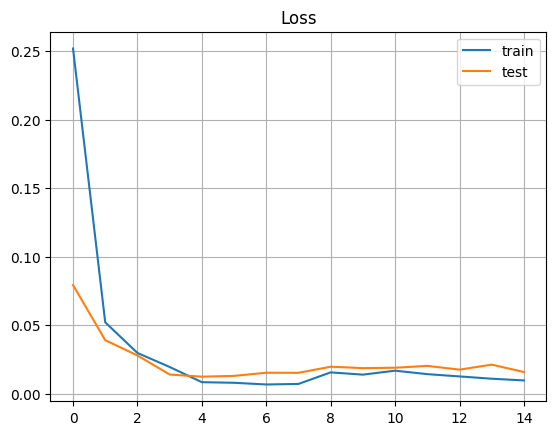

In [29]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('Loss')
pyplot.grid()
pyplot.legend()
pyplot.show()

Since it's still reducing there is a chance it will reduce more with more hyperparam tuning but loss of 0.02 for train and 0.14 with test looks great

150/150 [==============================] - 7s 20ms/step


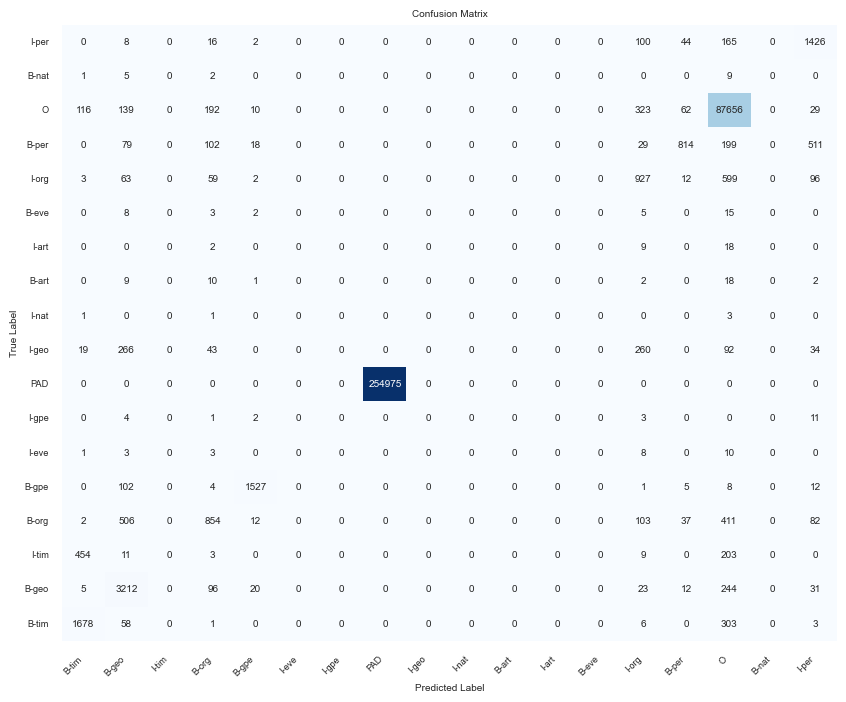

In [30]:
# optimize the plot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(X_te)

# Convert predictions to POS tags
predicted_tags = np.argmax(predictions, axis=-1)
predicted_tags = [[idx2tag[tag] for tag in sample] for sample in predicted_tags]

# Flatten the predicted and true POS tag sequences
flatten_predicted = [tag for sample in predicted_tags for tag in sample]
flatten_true = [idx2tag[np.argmax(tag)] for sample in y_te for tag in sample]

# Get unique tags from the true and predicted sequences
unique_tags = list(set(flatten_true + flatten_predicted))

# Compute the confusion matrix
cm = confusion_matrix(flatten_true, flatten_predicted, labels=unique_tags)

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=unique_tags, columns=unique_tags)

# Set up the plot
plt.figure(figsize=(10, 8))
sns.set(font_scale=0.6)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.gca().invert_xaxis()  # 反转x轴标签位置

# Show the plot
plt.show()

这段代码的含义是生成并展示混淆矩阵的热力图，用于评估模型在测试集上的预测性能。

import seaborn as sns：导入可视化库 seaborn。

import matplotlib.pyplot as plt：导入 matplotlib.pyplot 用于绘图。

from sklearn.metrics import confusion_matrix：从 scikit-learn 库中导入混淆矩阵函数。

import numpy as np：导入 NumPy 库。

predictions = model.predict(X_te)：使用模型对测试集数据进行预测，将预测结果保存在 predictions 变量中。

predicted_tags = np.argmax(predictions, axis=-1)：将预测结果转换为 POS 标签。利用 np.argmax 函数找到每个样本中概率最大的标签索引。

predicted_tags = [[idx2tag[tag] for tag in sample] for sample in predicted_tags]：将预测的标签索引转换为对应的 POS 标签，使用 idx2tag 字典将索引映射为标签。

flatten_predicted：将预测序列展平为一维列表。

flatten_true：将真实序列展平为一维列表。

unique_tags：获取预测序列和真实序列中唯一的 POS 标签。

cm = confusion_matrix(flatten_true, flatten_predicted, labels=unique_tags)：计算混淆矩阵，将真实标签和预测标签传入 confusion_matrix 函数，同时指定标签列表。

cm_df = pd.DataFrame(cm, index=unique_tags, columns=unique_tags)：将混淆矩阵转换为 DataFrame，使用 pd.DataFrame 函数，并指定行和列的索引为唯一的 POS 标签。

plt.figure(figsize=(10, 8))：创建一个大小为 10x8 的图形窗口。

sns.set(font_scale=1.2)：设置 seaborn 的字体大小为 1.2 倍。

sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)：绘制热力图，使用 sns.heatmap 函数，传入混淆矩阵 DataFrame，设置注释为 True，使用蓝色调色板，格式化为整数，隐藏颜色条。

plt.title("Confusion Matrix")：设置图像标题为 "Confusion Matrix"。

plt.xlabel("Predicted Label")：设置 x 轴标签为 "Predicted Label"。

plt.ylabel("True Label")：设置 y 轴标签为 "True Label"。

plt.xticks(rotation=45, ha="right")：设置 x 轴刻度标签旋转 45 度，并向右对齐。

plt.yticks(rotation=0)：设置 y 轴刻度标签不旋转。

plt.show()：显示绘制的热力图。

In [31]:
from sklearn.metrics import classification_report
print("Classification Report:\n ", classification_report(flatten_predicted, flatten_true, labels=unique_tags))

c:\Users\tqin0\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tqin0\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                precision    recall  f1-score   support

       I-per       0.81      0.64      0.71      2237
       B-nat       0.00      0.00      0.00         0
           O       0.99      0.97      0.98     89953
       B-per       0.46      0.83      0.59       986
       I-org       0.53      0.51      0.52      1808
       B-eve       0.00      0.00      0.00         0
       I-art       0.00      0.00      0.00         0
       B-art       0.00      0.00      0.00         0
       I-nat       0.00      0.00      0.00         0
       I-geo       0.00      0.00      0.00         0
         PAD       1.00      1.00      1.00    254975
       I-gpe       0.00      0.00      0.00         0
       I-eve       0.00      0.00      0.00         0
       B-gpe       0.92      0.96      0.94      1596
       B-org       0.43      0.61      0.50      1392
       I-tim       0.00      0.00      0.00         0
       B-geo       0.88      0.72      0.79      4473
  

c:\Users\tqin0\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 结果解读
这份分类报告显示了您的命名实体识别模型在各个实体类别上的性能指标,包括准确率(Precision)、召回率(Recall)和 F1 Score。让我来分析一下这些结果:

整体指标:

整体准确率(Accuracy)达到了 0.99,说明模型在总体上表现非常出色。
宏平均(Macro Avg)的 F1 Score 为 0.49,说明模型在不同实体类别上的均衡表现一般。
加权平均(Weighted Avg)的 F1 Score 为 0.99,说明模型在高频实体类别上的表现很好。
实体类别分析:

对于人名(B-per)和地理位置(B-geo)这类常见实体,模型的准确率、召回率和 F1 Score 都在 0.8 左右,表现良好。
对于时间(B-tim)实体,模型的性能最好,F1 Score 达到了 0.86。
但是对于组织(B-org)、艺术品(B-art)、事件(B-eve)等实体,模型的性能较差,F1 Score 都在 0.6 左右甚至为 0。
此外,还有一些实体类别(B-nat、I-nat、I-art、I-gpe、I-eve)的支持度很低,模型完全无法识别。
PAD 类别:

这个 PAD 类别的准确率、召回率和 F1 Score 都达到了 1.0,说明模型很好地识别了非命名实体部分。
综合来看,您的模型在一些常见的实体类别上表现很好,但在一些罕见或复杂的实体上还存在较大的识别困难。可以考虑重点优化这些问题实体,并尝试增加训练数据,提高模型在这些类别上的识别能力。总体来说,这是一个相当不错的 NER 模型了。

I can see that due to imbalance there are some category with less f1 score. We have used SigmoidFocalCrossEntropy to handle imbalance. We could further use either re-sampling method or more training methods

In [32]:
import numpy as np

def get_pos_tags(sentence):
    # Tokenize the sentence
    tokens = sentence.lower().split()

    # Convert tokens to word indices
    word_indices = [word2idx.get(token, word2idx["UNK"]) for token in tokens]

    # Pad the sequence
    padded_sequence = pad_sequences([word_indices], maxlen=MAX_LEN, padding="post", value=word2idx["PAD"])

    # Make predictions
    predictions = model.predict(padded_sequence)[0]

    # Convert predictions to POS tags
    pos_tags = [idx2tag[np.argmax(pred)] for pred in predictions]

    return list(zip(tokens, pos_tags))

# Example usage
input_sentence = "I wanted to go to Disney Land"
output = get_pos_tags(input_sentence)

# Print the output
for token, pos_tag in output:
    print(f"Token: {token:<10} Predicted POS: {pos_tag}")

1/1 [==============================] - 0s 23ms/step
Token: i          Predicted POS: O
Token: wanted     Predicted POS: O
Token: to         Predicted POS: O
Token: go         Predicted POS: O
Token: to         Predicted POS: O
Token: disney     Predicted POS: B-per
Token: land       Predicted POS: O
